<a href="https://colab.research.google.com/github/Dharamchandpatle/Refinery-AIML/blob/main/EnergyConsumptionPredictionModel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Energy Consumption Prediction Model
Energy Consumption & SEC Prediction (Prophet)





In [13]:
# Energy Consumption & SEC Prediction (Prophet)

In [14]:
# !pip install prophet


In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from prophet import Prophet
from google.colab import files


In [16]:
# UPLOAD DATASET (AUTOMATION ENTRY POINT)

uploaded = files.upload()
file_name = list(uploaded.keys())[0]

df = pd.read_csv(file_name)
print("Dataset uploaded:", file_name)
df.head()



Saving refinery_energy_sec_historical_prophet.csv to refinery_energy_sec_historical_prophet.csv
Dataset uploaded: refinery_energy_sec_historical_prophet.csv


,date,unit_name,electricity_kwh,steam_usage,fuel_usage,production_tons,total_energy,SEC
0,2023-05-14,VDU,83125.631706,40467.258382,31706.675639,2226.394896,155299.565727,69.753828
1,2024-09-23,NCU,74461.747074,49193.090853,36614.940254,1745.696047,160269.778181,91.808524
2,2022-08-23,VDU,86488.229163,43082.102144,35285.831519,1832.380506,164856.162826,89.968302
3,2021-03-17,DCU,87440.036175,37464.336152,23749.437474,1334.705471,148653.809801,111.375740
4,2024-11-18,NCU,80752.097196,40834.855238,36930.883801,1499.356646,158517.836235,105.723903


In [17]:
# BASIC DATA CLEANING (REQUIRED)


# Remove duplicates
df.drop_duplicates(inplace=True)

# Handle date column safely
if "date" in df.columns:
    df["date"] = pd.to_datetime(df["date"])
elif "ds" in df.columns:
    df["ds"] = pd.to_datetime(df["ds"])

# Handle missing values
df.fillna(df.median(numeric_only=True), inplace=True)

# Clean only if raw refinery data
required_cols = ["electricity_kwh", "steam_usage", "fuel_usage", "production_tons"]
if all(col in df.columns for col in required_cols):
    df = df[
        (df["electricity_kwh"] > 0) &
        (df["steam_usage"] > 0) &
        (df["fuel_usage"] > 0) &
        (df["production_tons"] > 0)
    ]

print("Cleaning completed")

df.info()


Cleaning completed
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   date             1460 non-null   datetime64[ns]
 1   unit_name        1460 non-null   object        
 2   electricity_kwh  1460 non-null   float64       
 3   steam_usage      1460 non-null   float64       
 4   fuel_usage       1460 non-null   float64       
 5   production_tons  1460 non-null   float64       
 6   total_energy     1460 non-null   float64       
 7   SEC              1460 non-null   float64       
dtypes: datetime64[ns](1), float64(6), object(1)
memory usage: 91.4+ KB


In [18]:
# =========================
# ROBUST FEATURE ENGINEERING (ONE CELL)
# =========================

import pandas as pd
import numpy as np

# ---- Column auto-mapping ----
column_map = {
    "electricity_kwh": ["electricity_kwh", "electricity", "elec_kwh", "power_kwh", "energy_kwh"],
    "steam_usage": ["steam_usage", "steam", "steam_kwh"],
    "fuel_usage": ["fuel_usage", "fuel", "fuel_kwh"],
    "production_tons": ["production_tons", "production", "output_tons"]
}

for standard_col, possible_cols in column_map.items():
    for col in possible_cols:
        if col in df.columns:
            df[standard_col] = df[col]
            break

# ---- Final validation ----
required_cols = ["electricity_kwh", "steam_usage", "fuel_usage", "production_tons"]
missing = [c for c in required_cols if c not in df.columns]

if missing:
    raise ValueError(f"Missing required columns: {missing}")

# ---- Feature Engineering ----
df["total_energy"] = (
    df["electricity_kwh"] +
    df["steam_usage"] +
    df["fuel_usage"]
)

df["SEC"] = df["total_energy"] / df["production_tons"]

print("Feature engineering completed successfully")
df[required_cols + ["total_energy", "SEC"]].head()


Feature engineering completed successfully


,electricity_kwh,steam_usage,fuel_usage,production_tons,total_energy,SEC
0,83125.631706,40467.258382,31706.675639,2226.394896,155299.565727,69.753828
1,74461.747074,49193.090853,36614.940254,1745.696047,160269.778181,91.808524
2,86488.229163,43082.102144,35285.831519,1832.380506,164856.162826,89.968302
3,87440.036175,37464.336152,23749.437474,1334.705471,148653.809801,111.375740
4,80752.097196,40834.855238,36930.883801,1499.356646,158517.836235,105.723903


In [19]:
# AGGREGATE DATA (TIME-SERIES FORMAT)
# Daily aggregation (best for refinery planning)


daily_df = df.groupby("date").agg({
    "total_energy": "sum",
    "SEC": "mean"
}).reset_index()

daily_df.head()


,date,total_energy,SEC
0,2021-01-02,331520.515792,113.107205
1,2021-01-04,187421.636096,134.722069
2,2021-01-05,194059.217732,98.370001
3,2021-01-06,163622.819708,79.454921
4,2021-01-09,508448.253530,95.146223


In [20]:
# PREPARE DATA FOR PROPHET (FORMAT RULE)
# Prophet requires:
# ds → date
# y → value to predict
# 🔹 ENERGY FORECAST DATASET

# TRAIN ENERGY CONSUMPTION MODEL


# Energy Forecast Dataset///////
energy_ts = daily_df.rename(columns={
    "date": "ds",
    "total_energy": "y"
})

# 🔹 SEC Forecast Dataset
sec_ts = daily_df.rename(columns={
    "date": "ds",
    "SEC": "y"
})



In [21]:

# TRAIN ENERGY FORECAST MODEL
energy_model = Prophet(
    yearly_seasonality=True,
    weekly_seasonality=True,
    changepoint_prior_scale=0.1
)

energy_model.fit(energy_ts)


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [22]:

# FORECAST FUTURE ENERGY (NEXT 30 DAYS)


future_energy = energy_model.make_future_dataframe(periods=30)
energy_forecast = energy_model.predict(future_energy)


energy_forecast.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2021-01-02,246647.224515,72967.724876,423936.205285,246647.224515,246647.224515,1967.043519,1967.043519,1967.043519,6400.664103,6400.664103,6400.664103,-4433.620583,-4433.620583,-4433.620583,0.0,0.0,0.0,248614.268035
1,2021-01-04,246746.552690,61600.173863,398474.203260,246746.552690,246746.552690,-14386.122393,-14386.122393,-14386.122393,-13955.982954,-13955.982954,-13955.982954,-430.139439,-430.139439,-430.139439,0.0,0.0,0.0,232360.430297
2,2021-01-05,246796.216777,72990.062410,426994.110758,246796.216777,246796.216777,-4628.790380,-4628.790380,-4628.790380,-6454.626536,-6454.626536,-6454.626536,1825.836156,1825.836156,1825.836156,0.0,0.0,0.0,242167.426397
3,2021-01-06,246845.880865,83488.911244,430201.362853,246845.880865,246845.880865,16128.438910,16128.438910,16128.438910,11961.157532,11961.157532,11961.157532,4167.281378,4167.281378,4167.281378,0.0,0.0,0.0,262974.319774
4,2021-01-09,246994.873126,95117.856609,454610.419669,246994.873126,246994.873126,17406.110485,17406.110485,17406.110485,6400.664103,6400.664103,6400.664103,11005.446382,11005.446382,11005.446382,0.0,0.0,0.0,264400.983612


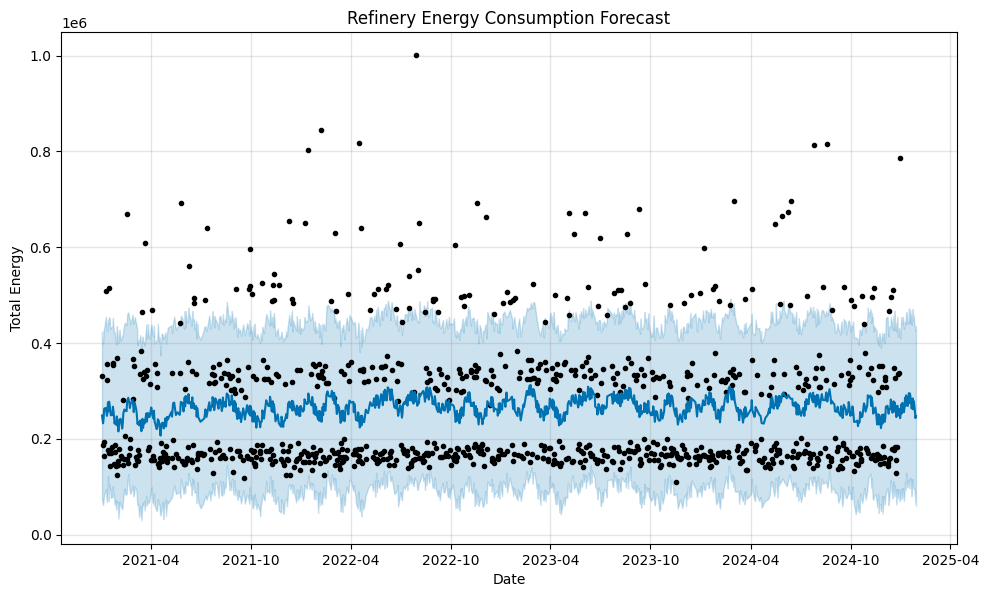

In [23]:
# VISUALIZE ENERGY FORECAST 📊


energy_model.plot(energy_forecast)
plt.title("Refinery Energy Consumption Forecast")
plt.xlabel("Date")
plt.ylabel("Total Energy")
plt.show()

In [24]:
# PREPARE SEC FORECAST DATASET

# SEC FORECAST MODEL (AUTO)


sec_ts = daily_df.rename(columns={
    "date": "ds",
    "SEC": "y"
})

# RAIN SEC FORECAST MODEL

sec_model = Prophet(
    yearly_seasonality=True,
    weekly_seasonality=False,
    changepoint_prior_scale=0.1
)

sec_model.fit(sec_ts)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


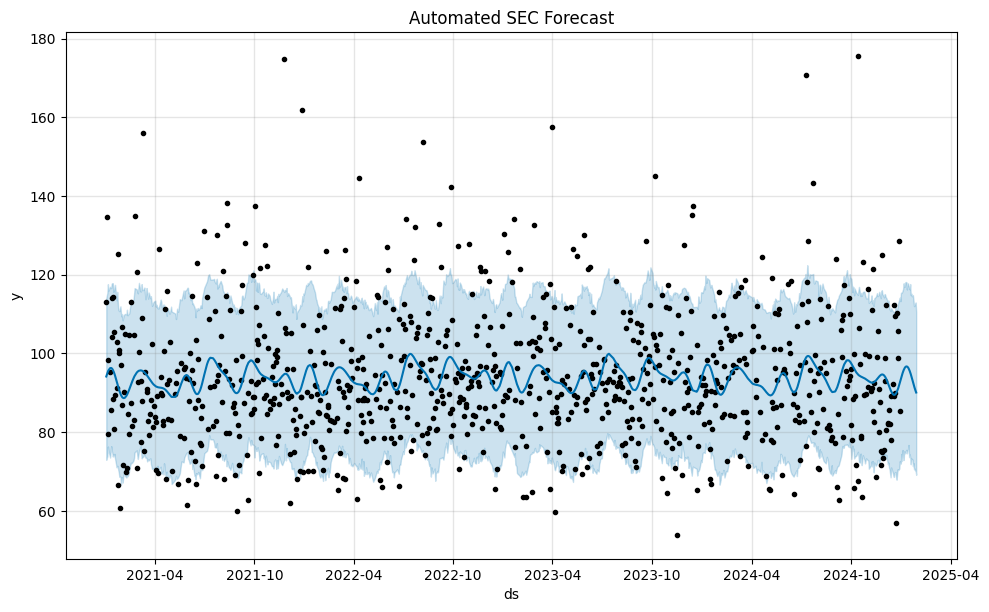

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2021-01-02,92.907608,72.949592,114.004371,92.907608,92.907608,1.206319,1.206319,1.206319,1.206319,1.206319,1.206319,0.0,0.0,0.0,94.113927
1,2021-01-04,92.910232,73.855289,115.358481,92.910232,92.910232,2.070233,2.070233,2.070233,2.070233,2.070233,2.070233,0.0,0.0,0.0,94.980465
2,2021-01-05,92.911544,76.323951,117.587359,92.911544,92.911544,2.438423,2.438423,2.438423,2.438423,2.438423,2.438423,0.0,0.0,0.0,95.349967
3,2021-01-06,92.912855,75.286690,115.929463,92.912855,92.912855,2.753933,2.753933,2.753933,2.753933,2.753933,2.753933,0.0,0.0,0.0,95.666789
4,2021-01-09,92.916791,73.511796,116.940241,92.916791,92.916791,3.327260,3.327260,3.327260,3.327260,3.327260,3.327260,0.0,0.0,0.0,96.244050


In [25]:
# FORECAST FUTURE SEC


# SEC FORECAST + VISUAL


future_sec = sec_model.make_future_dataframe(periods=30)
sec_forecast = sec_model.predict(future_sec)

sec_model.plot(sec_forecast)
plt.title("Automated SEC Forecast")
plt.show()

sec_forecast.head()

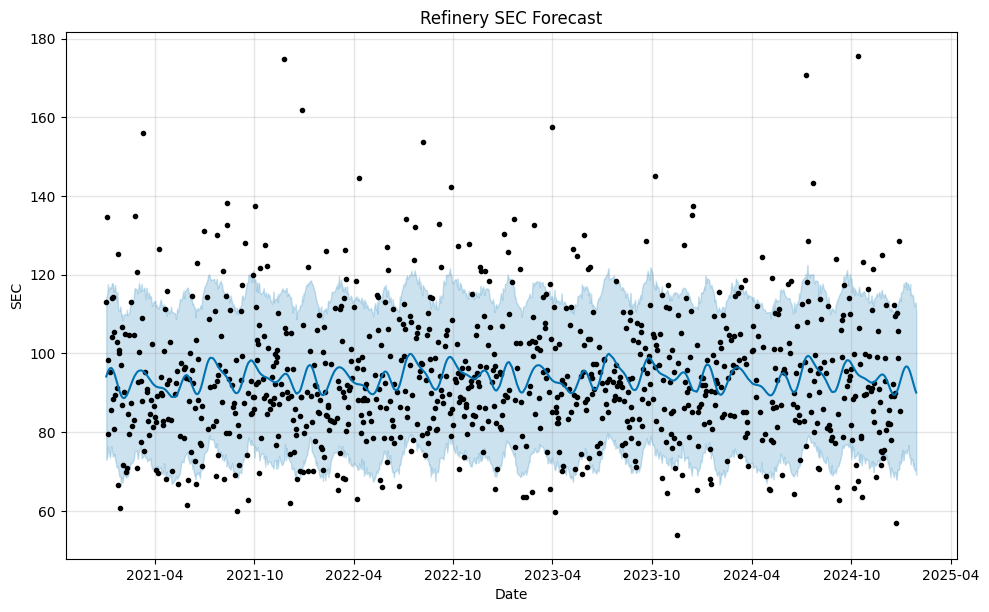

In [26]:
# VISUALIZE SEC FORECAST


sec_model.plot(sec_forecast)
plt.title("Refinery SEC Forecast")
plt.xlabel("Date")
plt.ylabel("SEC")
plt.show()

In [27]:
#AUTO SAVE OUTPUT FILES


energy_forecast[["ds", "yhat", "yhat_lower", "yhat_upper"]].to_csv(
    "energy_forecast.csv", index=False
)

sec_forecast[["ds", "yhat", "yhat_lower", "yhat_upper"]].to_csv(
    "sec_forecast.csv", index=False
)

print("Forecast files saved automatically")

Forecast files saved automatically


In [28]:
# DOWNLOAD RESULTS
# files.download("energy_forecast.csv")
# files.download("sec_forecast.csv")

In [30]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# Split actual & predicted
actual = energy_ts.tail(30)["y"].values
predicted = energy_forecast.tail(30)["yhat"].values

# MAE
mae = mean_absolute_error(actual, predicted)

# RMSE (manual – version safe)
rmse = np.sqrt(mean_squared_error(actual, predicted))

print("MAE:", mae)
print("RMSE:", rmse)


MAE: 119975.12102816539
RMSE: 150408.63988825548


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


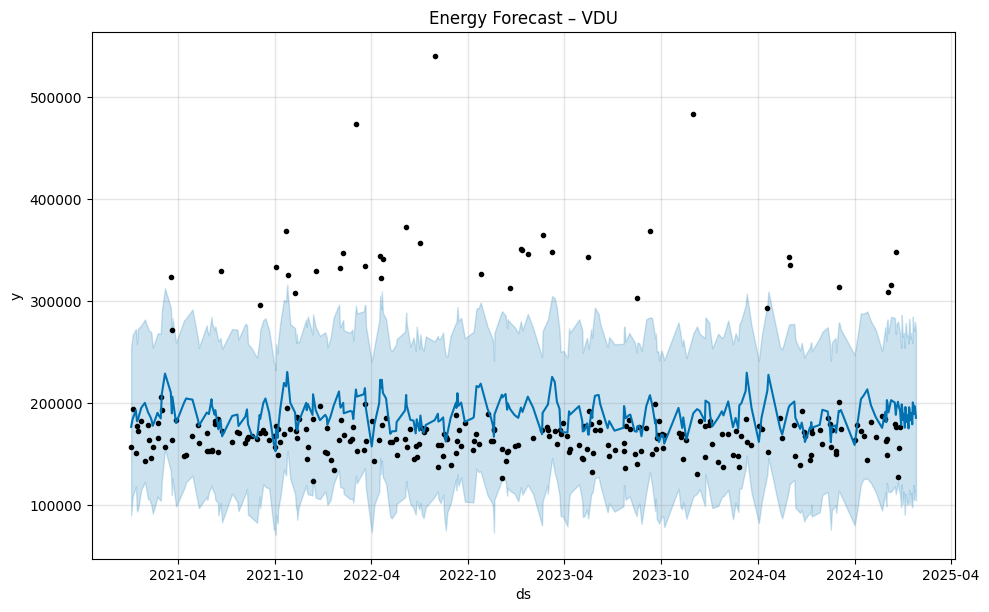

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


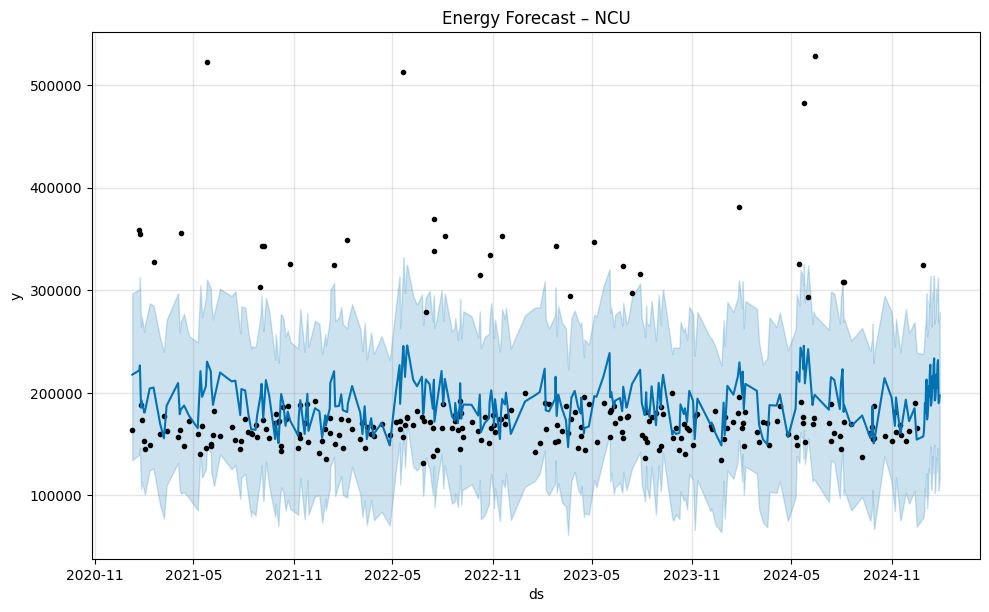

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


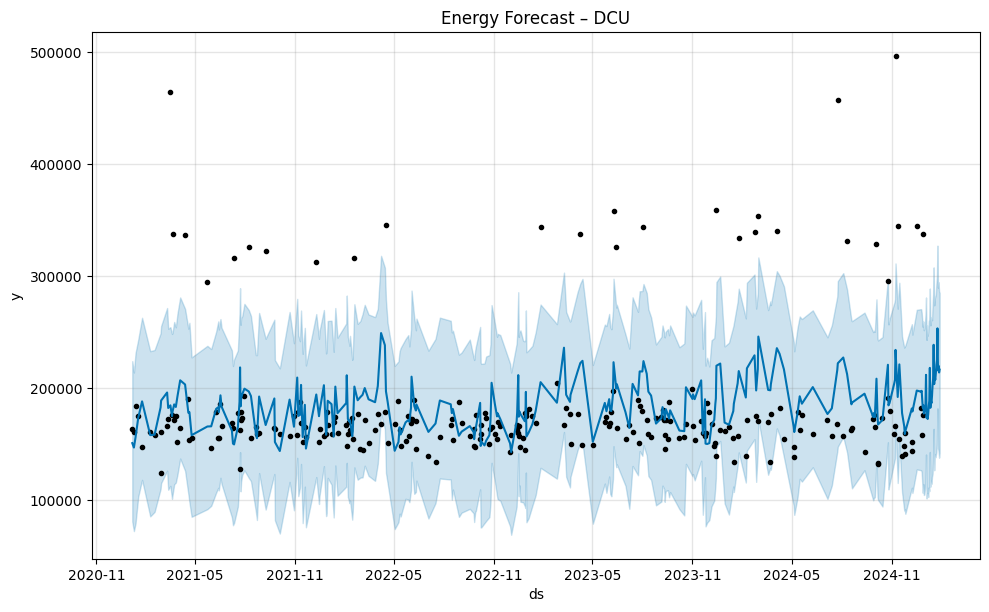

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


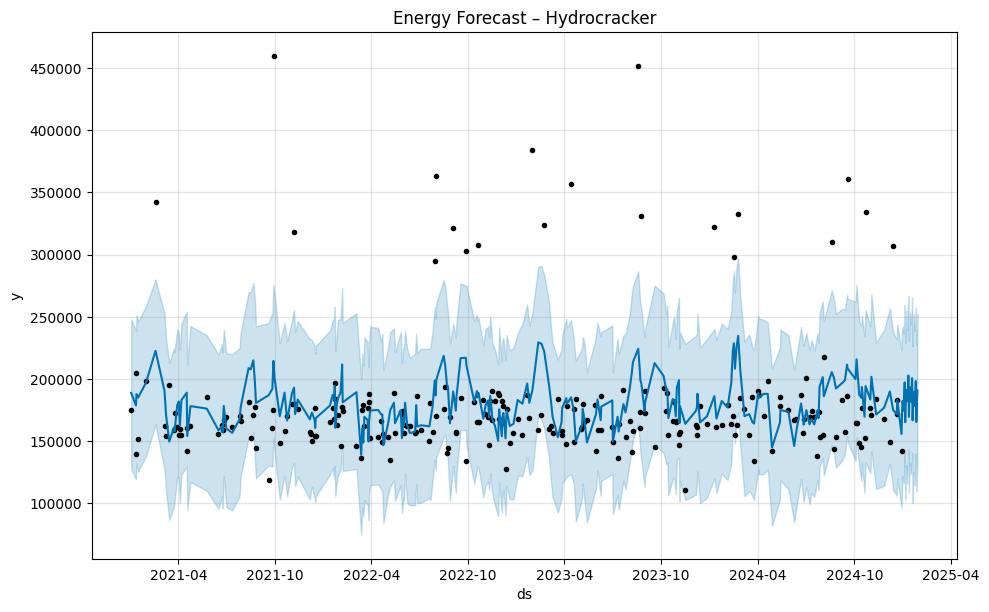

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


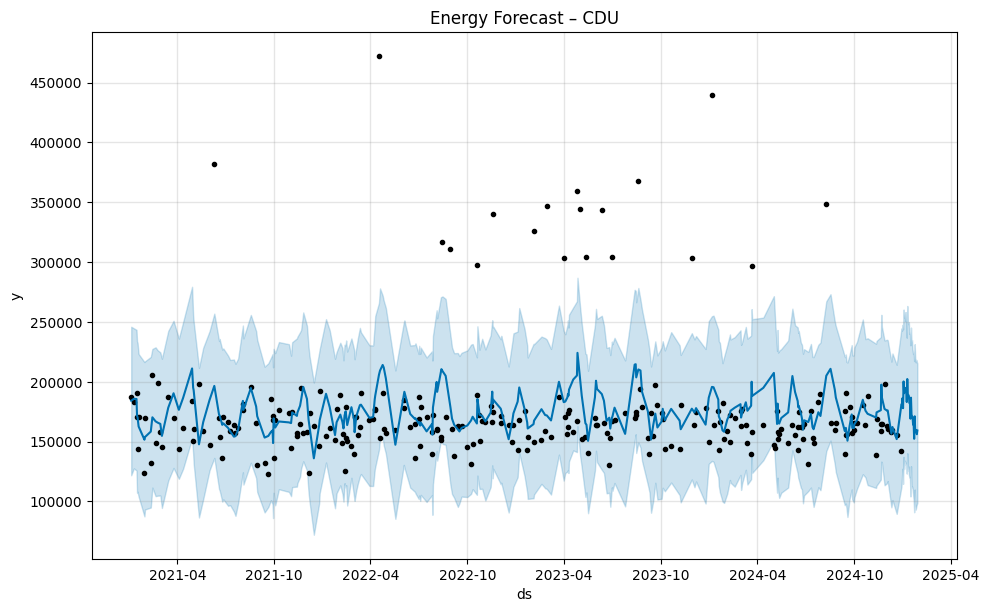

In [31]:
# UNIT-WISE FORECASTING (FUTURE SCOPE)
for unit in df["unit_name"].unique():
    unit_df = df[df["unit_name"] == unit]

    daily_unit = unit_df.groupby("date").agg({
        "total_energy": "sum"
    }).reset_index()

    unit_ts = daily_unit.rename(columns={"date": "ds", "total_energy": "y"})

    model = Prophet()
    model.fit(unit_ts)

    future = model.make_future_dataframe(periods=30)
    forecast = model.predict(future)

    model.plot(forecast)
    plt.title(f"Energy Forecast – {unit}")
    plt.show()